# Multi-Layer Perceptron, MNIST
---
In this notebook, we will train an MLP to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database. 
(**여기서 우리는 [MNIST 데이터베이스] 수기 숫자 데이터베이스에서 이미지를 분류하기 위해 MLP를 훈련시킬 것이다.**) 

The process will be broken down into the following steps:
>1. Load and visualize the data (데이터 로드 및 시각화)
2. Define a neural network (신경망 정의)
3. Train the model (모델 훈련)
4. Evaluate the performance of our trained model on a test dataset! (훈련 데이터세트에서 훈련된 모델의 성능평가)

Before we begin, we have to import the necessary libraries for working with data and PyTorch.

In [1]:
# import libraries
import torch
import numpy as np

---
## Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the `batch_size` if you want to load more data at a time. (데이터를 동일시간내에 더 많이 로드하고 싶으면 batch_size를 바꾸어라) 

This cell will create DataLoaders for each of our datasets. (아래의 셀은 각 데이터셋에 대한 데이터 로더를 생성한다)

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



### Visualize a Batch of Training Data (훈련 데이터 집단 시각화)

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

분류 작업의 첫 번째 단계는 데이터를 살펴보고 데이터가 올바르게 로드되었는지 확인한 다음, 해당 데이터의 패턴에 대한 초기 관측을 수행하는 것이다.

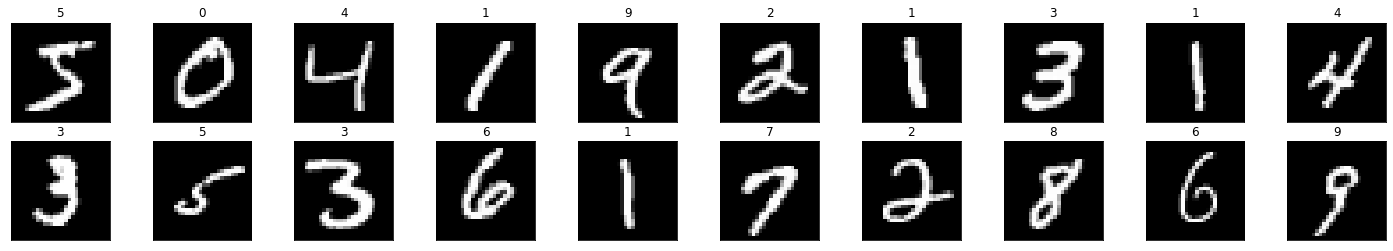

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### View an Image in More Detail (이미지 더 상세하게 관찰)

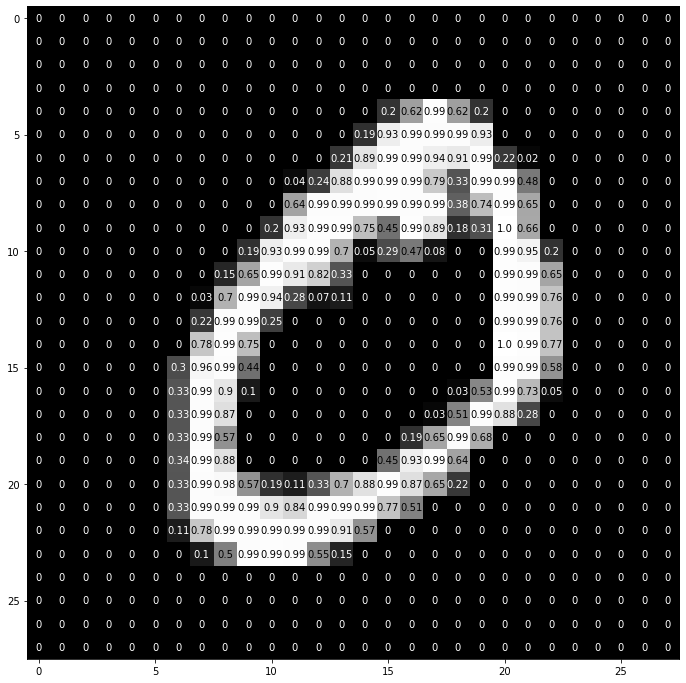

In [5]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)
## (네트워크 아키텍처 정의하기. 네트워크 아키텍처는 네트워크의 물리적인 요소들과 절차, 조직, 통신 프로토콜의 사양 등을 위한 프레임워크이다.)

The architecture will be responsible for seeing as input a 784-dim Tensor of pixel values for each image, and producing a Tensor of length 10 (our number of classes) that indicates the class scores for an input image. This particular example uses two hidden layers and dropout to avoid overfitting.

아키텍처는 각 이미지에 대한 픽셀 값의 784-dim 텐서를 입력으로 보고, 입력 이미지에 대한 클래스 점수를 나타내는 길이 10의 텐서를 생성하는 역할을 한다. 이 예제에서는 **과적합을 방지하기 위해 두 개의 숨겨진 레이어와 드롭아웃을 사용한다**.

In [6]:
import torch.nn as nn
import torch.nn.functional as F

## Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        # linear layer (n_hidden -> 10)
        self.fc2 = nn.Linear(512, 10)


    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


###  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

It's recommended that you use cross-entropy loss for classification. If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer *and* then calculates the log loss.

-> **분류에는 손실함수인 교차 엔트로피 오차를 쓰는 것이 좋다** 

In [7]:
## Specify loss and optimization functions

# specify loss function
criterion = nn.CrossEntropyLoss() # 손실함수 명시

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) # 최적화를 위한 프로그램(옵티마이저) 명시

---
## Train the Network (네트워크 훈련시키기)

The steps for training/learning from a batch of data are described in the comments below: 
데이터 집단에서 훈련/러닝하는 단계는 아래에 설명되어있다.)

1. Clear the gradients of all optimized variables (**최적화된 모든 변수의 그래디언트 지우기**)

2. Forward pass: compute predicted outputs by passing inputs to the model

(**Forward pass: 모델에 input을 전달하여 예측된 output을 계산한다.**)

(**Forward pass란 입력값을 받아서 loss 값을 구하기까지 계산해 가는 과정을 말한다**)

3. Calculate the loss (**손실을 계산한다.**)

4. Backward pass: compute gradient of the loss with respect to model parameters

(**Backward pass : 모델 배개변수에 대한 손실의 그래디언트 계산**)

(**Backward pass란 Forward pass가 끝난 후 역으로 미분해가면 그래디언트 값들을 구해가는 과정을 말한다**)

5. Perform a single optimization step (parameter update)

**단일 최적화 단계 수행(매개변수 업데이트)**

6. Update average training loss (**평균 훈련 손실 업데이트**)


In [8]:
# number of epochs to train the model
n_epochs = 10  # suggest training between 10-50 epochs 
# 10번 반복

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.396954
Epoch: 2 	Training Loss: 0.301176
Epoch: 3 	Training Loss: 0.287221
Epoch: 4 	Training Loss: 0.279641
Epoch: 5 	Training Loss: 0.274583
Epoch: 6 	Training Loss: 0.270847
Epoch: 7 	Training Loss: 0.267912
Epoch: 8 	Training Loss: 0.265510
Epoch: 9 	Training Loss: 0.263485
Epoch: 10 	Training Loss: 0.261740


# => 반복수(즉 모델 훈련 횟수)가 증가할수록 훈련 손실이 줄어든다

---
## Test the Trained Network (훈련된 네트워크 테스트하기)

Finally, we test our best model on previously unseen **test data** and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

마지막으로, 우리는 이전에 보지 못한 **테스트 데이터**로 최고의 모델을 테스트하고 성능을 평가한다. 이전에 보지 못한 데이터로의 테스트는 우리의 모델이 잘 일반화되는지 확인하는 좋은 방법이다. 또한 이러한 분석으로부터 세분화되어, 이 모델이 각 클래스에서 어떻게 작동하는지와 전반적인 손실 및 정확성을 살펴보기에도 유용하다.

#### `model.eval()`

`model.eval(`) will set all the layers in your model to evaluation mode. This affects layers like dropout layers that turn "off" nodes during training with some probability, but should allow every node to be "on" for evaluation!

**'model.eval()' 은 모델의 모든 층들을 평가모드로 설정한다. 이는 훈련 중 노드를 꺼버리는 dropout 층 등의 기능을 비활성화 시켜 추론 모드로 조정해주는 역할을 하지만, 모든 노드는 평가를 위해 on 상태가 되도록 허용해야 한다.**

---

++ **model.eval()은 메모리와는 관련이 없다**

++ **torch.no_grad()는 autograd engine을 비활성화 시켜 필요한 메모리를 줄여주고 연산속도를 증가시킨다. 하지만 model.eval()처럼 dropout 층을 비활성화 시키진 않는다.**

In [9]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.287335

Test Accuracy of     0: 98% (961/980)
Test Accuracy of     1: 98% (1115/1135)
Test Accuracy of     2: 86% (888/1032)
Test Accuracy of     3: 89% (908/1010)
Test Accuracy of     4: 91% (900/982)
Test Accuracy of     5: 92% (821/892)
Test Accuracy of     6: 93% (898/958)
Test Accuracy of     7: 89% (917/1028)
Test Accuracy of     8: 84% (822/974)
Test Accuracy of     9: 93% (941/1009)

Test Accuracy (Overall): 91% (9171/10000)


# => 시험 정확도 평균 91%

### Visualize Sample Test Results (샘플 테스트 결과 시각화)

This cell displays test images and their labels in this format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

**정확하게 분류된 예제의 경우 녹색이고, 잘못된 예측의 경우 빨간색**

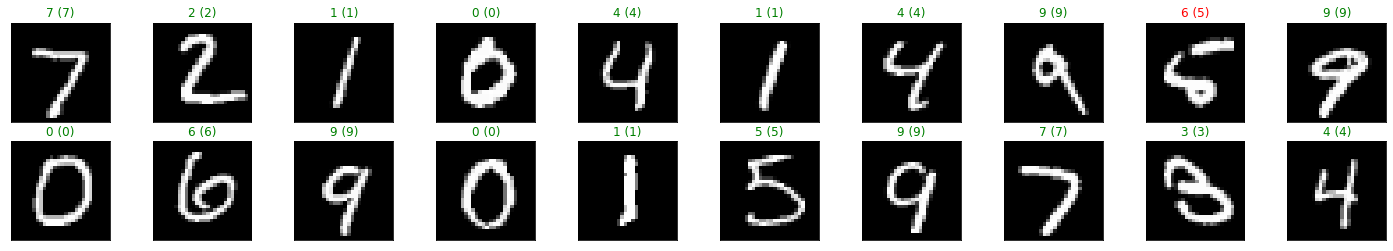

In [11]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))